In [1]:
# import mdtraj as md
import matplotlib.pyplot  as plt
import pyemma
# import seaborn as sns
import numpy as np
%matplotlib inline
from matplotlib.animation import FuncAnimation, PillowWriter, ArtistAnimation
# import mdshare

Implements the Torus grand tour. 
See:
* https://en.wikipedia.org/wiki/Grand_Tour_(data_visualisation)
* https://epubs.siam.org/doi/abs/10.1137/0906011



In [2]:
def torus_coordinates(k, p, scale):
    """
    alpha: R --> T^N
    returns the coordinates of a trajectory in a N-dimensional torus
    given a 'time' of k*scale*sqrt(2)
    k : frame
    p : dimension of data
    scale : controls the granularity
    """    
    N = int(2*p-3)
    primes = np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 
                       41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 
                       89, 97, 101, 103, 107, 109, 113, 127, 131, 
                       137, 139, 149, 151, 157, 163, 167, 173, 179, 
                       181, 191, 193, 197, 199, 211, 223, 227, 229, 
                       233, 239, 241, 251, 257, 263, 269, 271, 277,
                       281, 283, 293, 307, 311, 313, 317, 331, 337, 
                       347, 349, 353, 359, 367, 373, 379, 383, 389, 397])

    assert N <= len(primes), 'not implemented this many dimensions'
    lambdas = np.sqrt(primes[:N])
    step = np.sqrt(2)*scale
    coordinates = lambdas*step*k % 2*np.pi
    return coordinates

def angles(coordinates, p):
    """
    See appendix of the data. This maps the torus coordinates to rotations. 
    For N coordinates there are 2p-3 rotations. 
    Each rotation corresponds to a pair of axes of our data. 
    parameters
    ----------
    coordinates : the torus coordinates at a given frame
    p : the dimenion of our data
    returns
    -------
    angles : the rotations in radians
    ix : the dimensions of our data
    """
    angles = []
    ix = []
    for i in range(2):
        for j in range(i+1, p):
            angles.append(coordinates[j]-coordinates[i]) 
            ix.append([i, j])
            
    angles = np.array(angles)
    angles = angles % 2*np.pi
    return angles, ix

def Rij(theta, i,j, p=3):
    """
    Elements of SO(p).  Rotates i, j through angle theta.  I'm assuming this is what the paper means by: 
    "We let Rij(0) denote the element of SO(p) which rotates the standard basis vector e_i through an angle 
    0 towards the standard basis vector e_j inside the i, j coordinate 2-plane of R_p, leaving 
    fixed the orthogonal complement of this 2-plane."
    parameters
    ----------
    theta : the angle
    i, j : the indices
    p : the dimension
    returns
    -------
    R : p-dimensional rotation matrix. 
    """
    rot = np.array([[np.cos(theta), -np.sin(theta)], 
                    [np.sin(theta), np.cos(theta)]])
    R = np.eye(p)
    R[np.ix_([i, j], [i, j])] = rot
    return R
    

def rotations(k, p=3, scale=1e-2):
    """
    f : T^N --> SO(p)
    combines all the rotations
    parameters
    ----------
    k : the frame index
    p : the dimension
    fac : a scaling factor to control granularity
    returns
    -------
    Rotation matrix
    """
    R = np.eye(p)
    coords = torus_coordinates(k, p, scale=scale)
    thetas, ix = angles(coords, p)
    
    for i in range(thetas.shape[0]):
        R = Rij(thetas[i], ix[i][0],ix[i][1], p=p) @ R
    
    assert np.allclose(R @ R.T, np.eye(p)), "Rotation matrix isn't orthogonal"
    
    return R
    
def grand_tour_stop(frame, X, scale=1e-2, out_dim=2):
    """
    returns a stop on the grand tour.  
    parameters
    ----------
    frame: the 'stop' on the grand tour. 
    X : p-dimensional data
    scale : how close each 'stop' is to each other. 
    out_dim : we usually want a 2D output, but can output 3
    returns
    -------
    Xnew : a 2/3 dimensional data vector. 
    """
    assert out_dim in [2, 3], "Output dimension must be 2 or 3"
    
    p = X.shape[1]
    R = rotations(frame, p, scale=scale)
    Xnew = X @ R
    Xnew = Xnew[:, :out_dim]
    return Xnew
    
    

In [3]:
def create_gif(X, num_stops=100, out_file='grand_tour', out_dim=2, cols=None, scale=1e-2, fps=10, extent=2):
    """
    Creates a grand tour gif
    """
    if out_dim !=2: 
        raise NotImplementedError("Haven't done 3d projection yet")
        
    fig, ax = plt.subplots()
    scat = ax.scatter([], [])
    if cols is None: 
        cols = np.ones(X.shape[0])
        
    def init():
        ax.set_xlim(-extent, extent)
        ax.set_ylim(-extent, extent)
        return scat,

    def update(frame):
        Xnew = grand_tour_stop(frame, X, scale=scale, out_dim=out_dim)
        scat.set_offsets(Xnew[:, :2])
        scat.set_array(cols)
        return scat,

    animation = FuncAnimation(fig, update, frames=np.arange(num_stops),
                        init_func=init, blit=True)
    
    writergif = PillowWriter(fps=fps) 

    animation.save(out_file+'.gif', writer=writergif)

In [4]:
from pyemma.plots.plots2d import get_histogram, _to_free_energy


In [ ]:
Xvamp

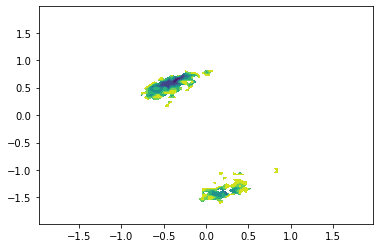

In [69]:
Lx = Ly = 2
Nx = Ny = 100
Nt = 10 # free energy levels

xx = np.linspace(-Lx, Lx, Nx)
yy = np.linspace(-Ly, Ly, Ny)

x, y, z = get_histogram(Xtica[:, 0], Xtica[:, 1], avoid_zero_count=False, nbins=[xx, yy])

fig, ax = plt.subplots()
f = _to_free_energy(z, minener_zero=True)
im = ax.contourf(x, y, f)

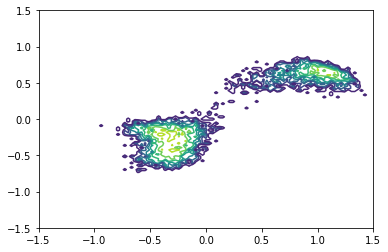

In [94]:
Lx = Ly = 1.5
Nx = Ny = 100
Nt = 10 # free energy levels

xx = np.linspace(-Lx, Lx, Nx)
yy = np.linspace(-Ly, Ly, Ny)
# xx,yy = np.meshgrid(x,y)


fig = plt.figure()
ax = plt.axes(xlim=(-Lx, Lx), ylim=(-Ly, Ly))

nframes = 1000
scale = 1e-3
out_dim=2
artists = []
for frame in range(nframes):
    Xnew = grand_tour_stop(frame, Xtica, scale=scale, out_dim=out_dim)
    x, y, z = get_histogram(Xnew[:, 0], Xnew[:, 1], avoid_zero_count=True, nbins=[xx, yy])
    f = _to_free_energy(z, minener_zero=True)
    im = ax.contour(x, y, f, cmap='viridis_r', levels=Nt)
    artists.append(im.collections)
    
ani = ArtistAnimation(fig, artists)

writergif = PillowWriter(fps=20) 


ani.save('test.gif', writer=writergif)

# Cubes

In [27]:
def ncube(dim=3, n=5):
    """
    dim : dimension
    n : number of points along each dimension
    """
    x = np.linspace(-1, 1, n)
    
    xs = np.meshgrid(*[x]*dim)
    X = np.concatenate([x.flatten()[:, None] for x in xs], axis=1)
    return X

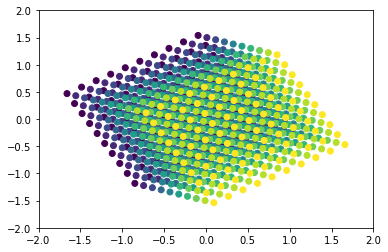

In [30]:
X = ncube(dim=3, n=10)
create_gif(X, out_file='cube3d', cols=X[:, 0])

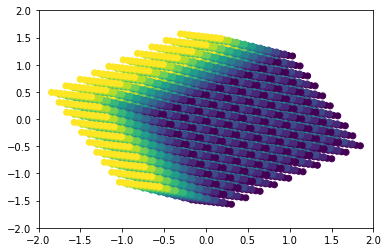

In [31]:
X = ncube(dim=4, n=10)
create_gif(X, out_file='cube4d', cols=X[:, 0])

# Pentapeptide

**data corrupted?**

Adapted from http://www.emma-project.org/latest/tutorials/notebooks/02-dimension-reduction-and-discretization.html#Case-3:-another-molecular-dynamics-data-set-(pentapeptide)

First get data and featurize

In [38]:
# Run this once. Also enable scrolling!
# pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
# files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

In [25]:
# feat = pyemma.coordinates.featurizer(pdb)
# feat.add_backbone_torsions(cossin=True, periodic=False)
# feat.add_sidechain_torsions(which='all', cossin=True, periodic=False)
# data_torsions = pyemma.coordinates.load(files, features=feat)

# feat.active_features = []
# feat.add_distances_ca(periodic=False)
# data_dists_ca = pyemma.coordinates.load(files, features=feat)


Now do dimensionality reduction.  We'll stick with three dimensions at first

In [24]:
# dim = 3
# lag = 20
# stride = 100

# vamp = pyemma.coordinates.vamp(data_torsions, lag=lag, dim=dim)
# pca = pyemma.coordinates.pca(data_torsions, dim=dim)
# tica = pyemma.coordinates.tica(data_torsions, lag=lag, dim=dim)

# Xvamp = np.concatenate(vamp.get_output())
# Xpca = np.concatenate(pca.get_output())
# Xtica = np.concatenate(tica.get_output())

# Alanine dipeptide

In [6]:
def get_colors(X, lag=1, k=100):
    clus = pyemma.coordinates.cluster_kmeans(X, k=k, max_iter=100)
    dtrajs = clus.dtrajs
    mm = pyemma.msm.estimate_markov_model(dtrajs, lag=lag)
    colors = mm.pi[dtrajs]
    return colors

In [91]:
trajs = [np.load('../../ala1/data/features/positions/{:03d}.npy'.format(i)) for i in range(750)]

lag = 5
dim = 4
stride = 100

tica = pyemma.coordinates.tica(trajs, lag=lag, dim=dim)
vamp = pyemma.coordinates.vamp(trajs, lag=lag, dim=dim)
pca  = pyemma.coordinates.pca(trajs, dim=dim)

Xvamp = np.concatenate(vamp.get_output())[::stride]
Xpca = np.concatenate(pca.get_output())[::stride]
Xtica = np.concatenate(tica.get_output())[::stride]

Vcols = get_colors(Xvamp)
Pcols = get_colors(Xpca) 
Tcols = get_colors(Xtica)

100%|██████████| 100/100 [00:00<00:00, 637.60it/s]                            

100%|██████████| 100/100 [00:00<00:00, 241.48it/s]                 
/Users/robertarbon/opt/miniconda3/envs/pyemma/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """
100%|██████████| 100/100 [00:00<00:00, 736.41it/s]                            

100%|██████████| 100/100 [00:00<00:00, 351.10it/s]                
/Users/robertarbon/opt/miniconda3/envs/pyemma/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result

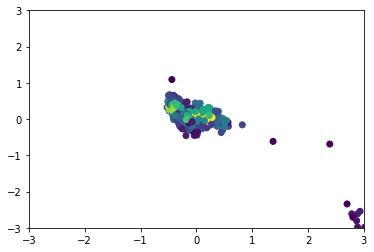

In [22]:
create_gif(Xtica, num_stops=1000, out_file='tica_ala', out_dim=2, cols=Tcols, scale=1e-2, fps=10, extent=3)

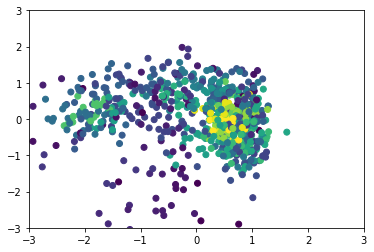

In [26]:
create_gif(Xvamp, num_stops=500, out_file='vamp_ala', out_dim=2, cols=Tcols, scale=1e-2, fps=10, extent=3)

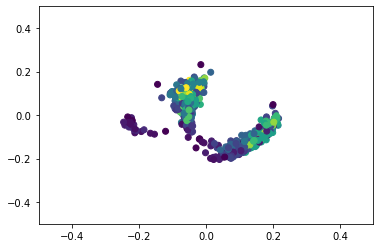

In [25]:
create_gif(Xpca, num_stops=1000, out_file='pca_ala', out_dim=2, cols=Tcols, scale=1e-2, fps=10, extent=0.5)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

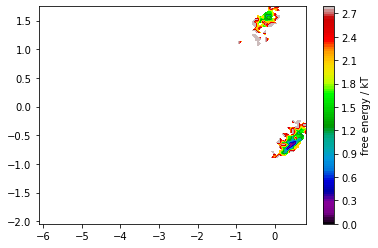

In [28]:
pyemma.plots.plot_free_energy(Xvamp[:, 0],Xvamp[:, 1])